In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from tensorflow.keras.applications.vgg16 import preprocess_input
def preprocess_img(x):
    return preprocess_input(x, mode='tf')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
classes = [16, 23,26, 27, 31, 32, 33, 35, 36]

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.models import Model, Sequential, Input
from keras.layers import *
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
import PIL
import time

Using TensorFlow backend.


In [4]:
path_data = '../garbage_classify/train_data'
batch_size = 48
img_width = 224
img_height = 224
img_size = 224
# img_width = 299
# img_height = 299
# img_size = 299
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

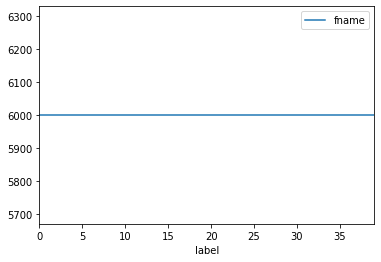

In [5]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [6]:
labels_train = labels_train[labels_train.label.isin(classes)]
labels_valid = labels_valid[labels_valid.label.isin(classes)]

labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')

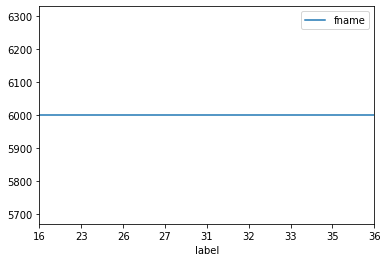

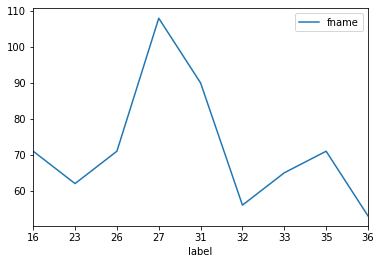

In [7]:
labels_train.groupby(by='label').count().plot()
labels_valid.groupby(by='label').count().plot()

In [8]:
ig = ImageDataGenerator(preprocessing_function=preprocess_img)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)

Found 54000 validated image filenames belonging to 9 classes.
Found 647 validated image filenames belonging to 9 classes.


In [9]:
base_model = Xception(
    weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
x=Dropout(0.3)(x)

predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
ckpt = ModelCheckpoint(
    '../tmp/ckpt-bottles-GPU'+os.environ["CUDA_VISIBLE_DEVICES"]+'-'+time.strftime('%Y-%m-%d_%H_%M')+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc')
estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,
                      verbose=1, patience=20)


In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1125/1125 [==============================] - 638s 567ms/step - loss: 0.4265 - acc: 0.8615 - val_loss: 0.5712 - val_acc: 0.8558
Epoch 2/100
1125/1125 [==============================] - 668s 594ms/step - loss: 0.0386 - acc: 0.9883 - val_loss: 0.6817 - val_acc: 0.8381
Epoch 3/100
1125/1125 [==============================] - 668s 593ms/step - loss: 0.0266 - acc: 0.9916 - val_loss: 0.7000 - val_acc: 0.8648
Epoch 4/100
1125/1125 [==============================] - 661s 588ms/step - loss: 0.0245 - acc: 0.9922 - val_loss: 0.7903 - val_acc: 0.8497
Epoch 5/100
1125/1125 [==============================] - 660s 587ms/step - loss: 0.0184 - acc: 0.9947 - val_loss: 0.7582 - val_acc: 0.8664
Epoch 6/100
1125/1125 [==============================] - 660s 587ms/step - loss: 0.0187 - acc: 0.9944 - val_loss: 0.6929 - val_acc: 0.8514
Epoch 7/100
1125/1125 [==============================] - 661s 587ms/step - loss: 0.0146 - acc: 0.9955 - val_loss: 0.81